In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_multi import *


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [13]:
def load_model(uuid):
    api = wandb.Api()
    runs = api.runs('yermandy/test', per_page=1000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            params.val_loss_best = run.summary['val loss best']
            break
            
    split_indices = get_split_indices(params)
    
    model = ResNet18(num_classes=10).to(device)
    weights = torch.load(f'weights/multi/model_{uuid}.pth', device)
    model.load_state_dict(weights)
    return model, params


def plot_nn_outputs(T, E, results):
    # results = np.convolve(results, np.ones(3), 'valid')

    fig, ax1 = plt.subplots(figsize=(60, 6))
    ax2 = ax1.twinx()
    ax1.step(T, results, where='post')
    ax1.hlines(1.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)
    ax1.hlines(2.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)
    
    for t in T:
        ax1.vlines(t, 0, 2, color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
     
    
def plot_nn_cumsum(T, E, results):
    cumsum = np.cumsum(results)

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(np.append(E, T[-1]), range(len(E) + 1), where='post');

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
        
def plot_nn_cumsum_2(T, E, results):
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(T, cumstep, where='post');

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
        
def plot_events_density(loader):
    events_per_window = []
    for x, y in loader:
        y = y.numpy()
        events_per_window.extend(y)

    fig, ax = plt.subplots()
    labels, counts = np.unique(events_per_window, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
    
def test(uuid, FROM_TIME, TILL_TIME):
    model, params = load_model(uuid)

    dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
    loader = DataLoader(dataset, batch_size=64)
    
    params.val = get_additional_params(
        params, signal, events, start_time=FROM_TIME, end_time=TILL_TIME
    )

    val_results = validate_multi(model, dataset, params.val, tqdm=tqdm)
    
    return val_results, params, loader

In [7]:
signal = load_audio('data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav')
events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')

In [8]:
uuid = 1628070563
FROM_TIME = 1 * 60
TILL_TIME = 25 * 60

results, params, loader = test(uuid, FROM_TIME, TILL_TIME)

  0%|          | 0/479 [00:00<?, ?it/s]

/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


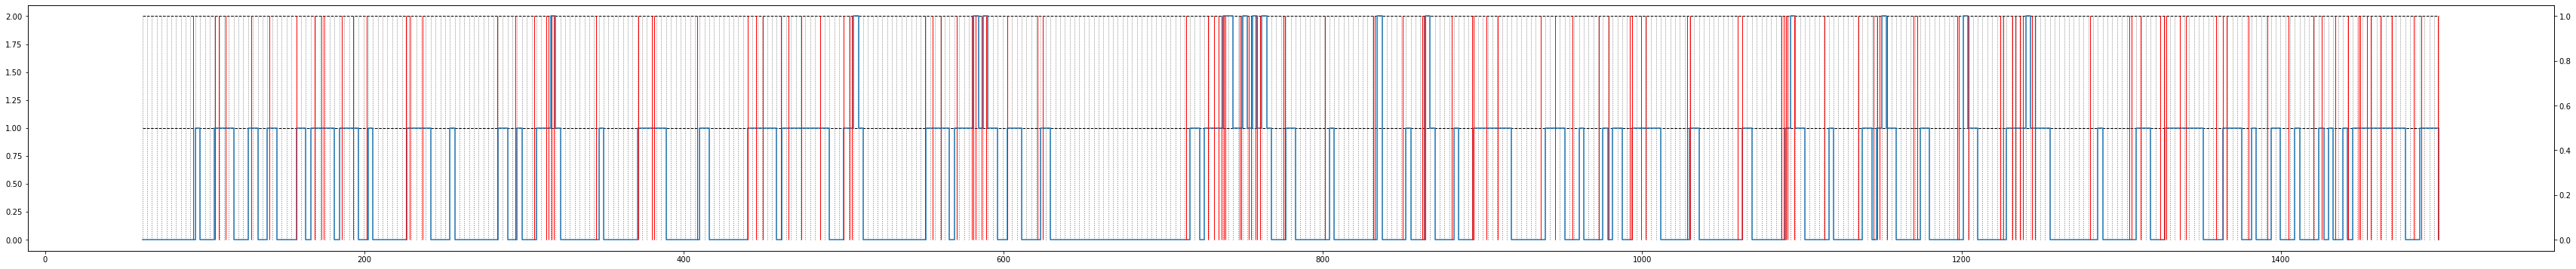

In [14]:
plot_nn_outputs(params.val.time, params.val.events, results)

diff: 36.3779


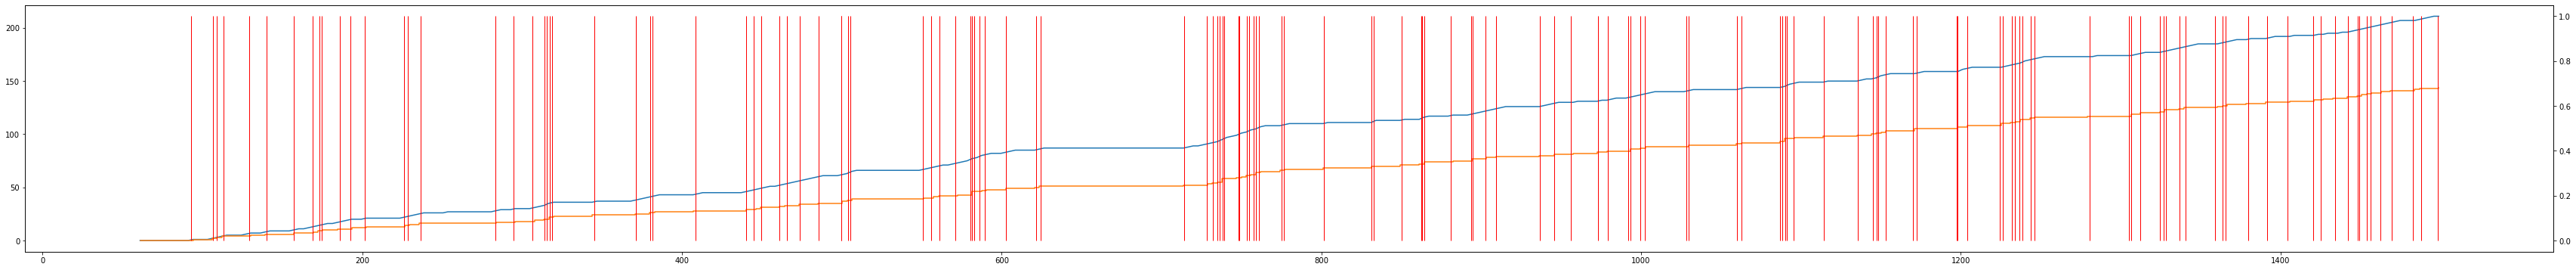

In [10]:
plot_nn_cumsum_2(params.val.time, params.val.events, results)

[47 44  3]


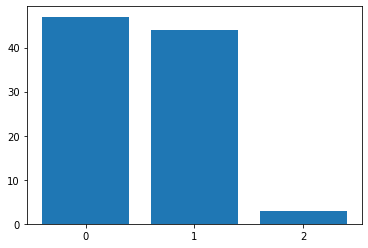

In [16]:
plot_events_density(loader)

In [14]:
model = ResNet18(num_classes=10).to(device)
dataset = VehicleDataset(audio_file, labels_file)

weights = torch.load(f'weights/multi/model_1627302338.pth', device)
model.load_state_dict(weights)

all: 298 | positive: 194


<All keys matched successfully>

In [29]:
results = []

offset = 0
start_time = 1 * 60
T = 25 * 60

frame_len = 5.0
n_samples_per_frame = int(sr * frame_len)

X = np.linspace(0, T, int(T))

model.eval()
with torch.no_grad():
    for t in tqdm(X):
        
        t = int((t + start_time + offset) * sr)
    
        s = signal[t: t + n_samples_per_frame]
        s = dataset.transform(s)
        s = s.unsqueeze(0).to(device)
        y = model(s)
        y = torch.argmax(y).item()
        
        results.append(y)

  0%|          | 0/1500 [00:00<?, ?it/s]

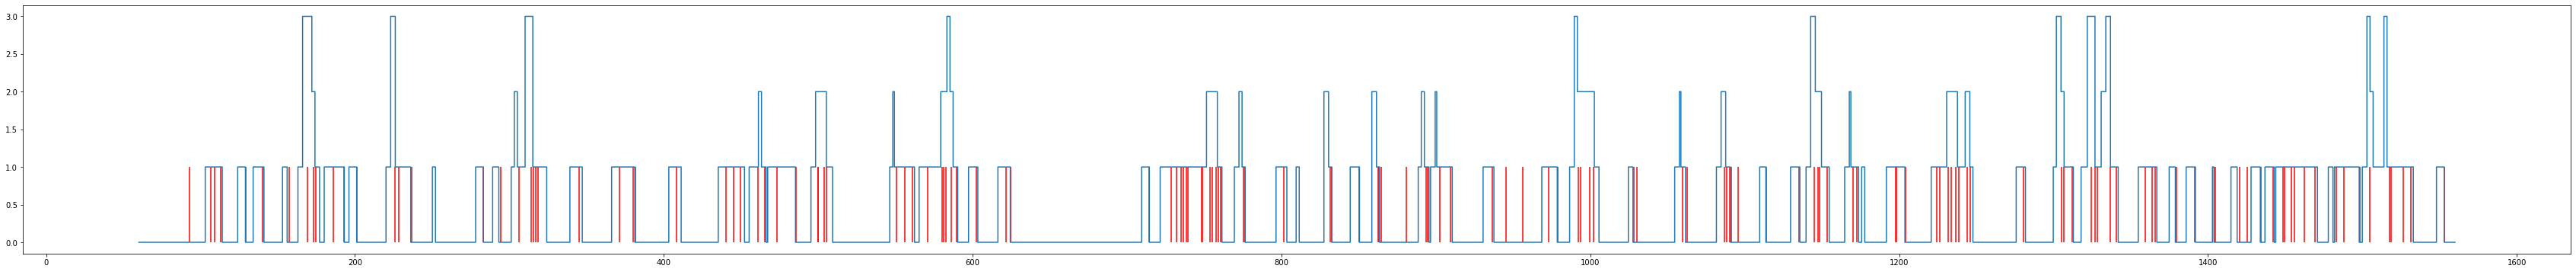

In [30]:
plt.figure(figsize=(60, 6))
plt.step(X + start_time, results);

for event in events[(events >= start_time) & (events < start_time + T)]:
    plt.vlines(event, 0, 1, color='r')